In [3]:
# Step 1: Install necessary packages
!pip install ultralytics
!pip install opencv-python
!pip install matplotlib
!pip install easyocr

# Step 2: Import libraries
import easyocr
import torch
import torch.nn.functional as F
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO  # Assuming you are using the YOLO library from ultralytics

reader = easyocr.Reader(['en'])  # 'en' stands for English. You can add more languages if needed.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 38.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Install the correct PyTorch version for Colab (CUDA version is 11.7)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

# Install pre-built wheels for torch-geometric and its dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu117.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu117.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu117.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu117.html
!pip install torch-geometric

Looking in indexes: https://download.pytorch.org/whl/cu117
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 70.5 MB/s eta 0:00:0000:010:01
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 53.8 MB/s eta 0:00:0000:0100:01
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.0 MB/s eta 0:00:0000:0100:01
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.2/887.2 kB 18.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.4 MB/s eta 0:00:00


In [5]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
import easyocr
from IPython.display import display, HTML
import numpy as np

# Load models globally
# Update the paths to your models as necessary
table_model = YOLO('/kaggle/input/model/other/default/1/bestDetection.pt', task='detect')
row_det_model = YOLO('/kaggle/input/cols-rows-detection-model/onnx/default/1/row_v0.onnx', task='detect')
column_det_model = YOLO('/kaggle/input/cols-rows-detection-model/onnx/default/1/col_v0.onnx', task='detect')
row_seg_model = YOLO('/kaggle/input/segmentation-model/other/default/1/seg_row_v0.onnx', task='segment')
column_seg_model = YOLO('/kaggle/input/segmentation-model/other/default/1/seg_col_v0.onnx', task='segment')
reader = easyocr.Reader(['en'])

def load_image(image_path):
    """Load an image from the specified path and convert it to RGB."""
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def detect_model(image, model):
    """Use the specified YOLO model to detect objects in the image."""
    results = model.predict(source=image)
    if not results:
        return []
    return results[0].boxes

def extract_boxes(boxes):
    """Extract bounding boxes as tuples (x1, y1, x2, y2)."""
    return [(int(box.xyxy[0][0]), int(box.xyxy[0][1]), 
             int(box.xyxy[0][2]), int(box.xyxy[0][3])) for box in boxes]

def sort_boxes(boxes, axis='y'):
    """
    Sort bounding boxes based on the specified axis.

    Parameters:
    - boxes: List of bounding boxes, each defined as (x1, y1, x2, y2).
    - axis: 'y' for rows (top to bottom), 'x' for columns (left to right).

    Returns:
    - Sorted list of bounding boxes.
    """
    if axis == 'y':
        # Sort by the top y-coordinate
        sorted_boxes = sorted(boxes, key=lambda box: box[1])
    elif axis == 'x':
        # Sort by the left x-coordinate
        sorted_boxes = sorted(boxes, key=lambda box: box[0])
    else:
        raise ValueError("Axis must be 'x' or 'y'")
    return sorted_boxes

def calculate_cells(sorted_rows, sorted_cols):
    """
    Calculate cell positions based on sorted rows and columns.

    Parameters:
    - sorted_rows: List of sorted row bounding boxes.
    - sorted_cols: List of sorted column bounding boxes.

    Returns:
    - List of cells with assigned row and column indices and their coordinates.
    """
    cells = []
    for row_idx in range(len(sorted_rows) - 1):
        for col_idx in range(len(sorted_cols) - 1):
            # Define cell coordinates based on intersecting row and column boundaries
            x1 = sorted_cols[col_idx][0]
            y1 = sorted_rows[row_idx][1]
            x2 = sorted_cols[col_idx + 1][2]
            y2 = sorted_rows[row_idx + 1][3]
            cell = {
                'row': row_idx,
                'column': col_idx,
                'cell_coords': (x1, y1, x2, y2)
            }
            cells.append(cell)
    return cells

def sort_cells_by_position(cells):
    """
    Sort cells first by row index, then by column index.

    Parameters:
    - cells: List of cell dictionaries.

    Returns:
    - Sorted list of cells.
    """
    return sorted(cells, key=lambda cell: (cell['row'], cell['column']))

def normalize_indices(cells):
    """
    Normalize row and column indices to ensure they start from 0.

    Parameters:
    - cells: List of cell dictionaries.

    Returns:
    - Cells with normalized 'row' and 'column' indices.
    """
    min_row = min(cell['row'] for cell in cells) if cells else 0
    min_col = min(cell['column'] for cell in cells) if cells else 0

    # Adjust row and column indices to start from 0
    for cell in cells:
        cell['row'] -= min_row
        cell['column'] -= min_col

    return cells

def visualize_boxes(image, boxes, color, title):
    """
    Visualize bounding boxes on the image.

    Parameters:
    - image: The image on which to draw.
    - boxes: List of bounding boxes as (x1, y1, x2, y2).
    - color: Color of the bounding box edges.
    - title: Title of the plot.
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(image)
    for box in boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
    ax.set_title(title)
    plt.axis('off')
    plt.show()

def visualize_sorted_rows_cols(image, sorted_rows, sorted_cols):
    """
    Visualize sorted rows and columns on the image.

    Parameters:
    - image: The image on which to draw.
    - sorted_rows: List of sorted row bounding boxes.
    - sorted_cols: List of sorted column bounding boxes.
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(image)
    
    # Draw rows in green
    for row in sorted_rows:
        x1, y1, x2, y2 = row
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
    
    # Draw columns in blue
    for col in sorted_cols:
        x1, y1, x2, y2 = col
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
    
    ax.set_title("Sorted Rows (Green) and Columns (Blue)")
    plt.axis('off')
    plt.show()

def visualize_sorted_cells(image, cells):
    """
    Visualize sorted cells with order numbers.

    Parameters:
    - image: The image on which to draw.
    - cells: List of cell dictionaries with 'cell_coords'.
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(image)

    for idx, cell in enumerate(cells):
        x1, y1, x2, y2 = cell['cell_coords']
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5, 
                                 edgecolor='purple', facecolor='none')
        ax.add_patch(rect)
        ax.text(
            x1 + (x2 - x1) / 2, y1 + (y2 - y1) / 2, str(idx + 1),
            color='white', ha='center', va='center', fontsize=8, backgroundcolor='black'
        )
    ax.set_title("Sorted Cells with Order Numbers")
    plt.axis('off')
    plt.show()

def perform_ocr(cells, table_image):
    """
    Perform OCR on each cell and store the result in the 'text' field.

    Parameters:
    - cells: List of cell dictionaries with 'cell_coords'.
    - table_image: The cropped image of the table.

    Returns:
    - Cells with added 'text' field containing OCR results.
    """
    for cell in cells:
        x1, y1, x2, y2 = cell['cell_coords']
        cell_image = table_image[y1:y2, x1:x2]
        # Optional: Preprocess cell_image for better OCR results
        # cell_image = cv2.cvtColor(cell_image, cv2.COLOR_RGB2GRAY)
        # cell_image = cv2.threshold(cell_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        ocr_results = reader.readtext(cell_image)
        cell['text'] = ' '.join([res[1] for res in ocr_results]).strip()
    return cells

def generate_html_table_with_content(cells, num_rows, num_cols):
    """
    Generate HTML table based on detected cells and their content.

    Parameters:
    - cells: List of cell dictionaries with 'row', 'column', and 'text'.
    - num_rows: Total number of rows in the table.
    - num_cols: Total number of columns in the table.

    Returns:
    - A string containing the HTML representation of the table.
    """
    # Initialize the table with empty strings
    table_data = [['' for _ in range(num_cols)] for _ in range(num_rows)]

    # Map each cell's text to the correct table position
    print("Mapping Cells to Rows and Columns:")
    for cell in cells:
        row = cell['row']
        col = cell['column']
        text = cell.get('text', '')
        print(f"Cell at (row={row}, col={col}): {text}")
        table_data[row][col] = text

    # Build the HTML table
    html = '<table border="1" style="border-collapse: collapse; width: 100%;">\n'
    for i, row_data in enumerate(table_data):
        html += '  <tr>\n'
        for cell_text in row_data:
            if i == 0:
                # Header row
                html += f'    <th style="padding: 8px; background-color: #f2f2f2;">{cell_text}</th>\n'
            else:
                # Data rows
                html += f'    <td style="padding: 8px;">{cell_text}</td>\n'
        html += '  </tr>\n'
    html += '</table>'
    return html

def display_html_table(html):
    """
    Display the HTML table in an IPython environment.

    Parameters:
    - html: A string containing the HTML representation of the table.
    """
    display(HTML(html))

def detect_and_crop(image, model):
    """
    Detect objects using the specified model and crop them from the image.

    Parameters:
    - image: The source image.
    - model: The YOLO model to use for detection.

    Returns:
    - boxes: List of bounding boxes.
    - cropped_images: List of cropped images based on bounding boxes.
    """
    results = detect_model(image, model)
    boxes = extract_boxes(results)
    cropped_images = []
    for box in boxes:
        x1, y1, x2, y2 = box
        cropped = image[y1:y2, x1:x2]
        cropped_images.append(cropped)
    return boxes, cropped_images

def process_image(image_path):
    """
    Main pipeline to process the image and generate HTML output.

    Parameters:
    - image_path: Path to the input image containing tables.
    """
    image = load_image(image_path)

    # Detect tables
    table_results = detect_model(image, table_model)
    table_boxes = extract_boxes(table_results)
    visualize_boxes(image, table_boxes, 'red', 'Detected Tables')

    for idx, table_box in enumerate(table_boxes):
        print(f"\nProcessing Table {idx + 1}...")

        # Crop the table from the image
        x1, y1, x2, y2 = table_box
        table_image = image[y1:y2, x1:x2]

        # Detect rows within the table
        row_results = detect_model(table_image, row_seg_model)
        row_boxes = extract_boxes(row_results)
        sorted_rows = sort_boxes(row_boxes, axis='y')
        visualize_boxes(table_image, sorted_rows, 'green', 'Detected Rows')

        # Detect columns within the table
        col_results = detect_model(table_image, column_seg_model)
        column_boxes = extract_boxes(col_results)
        sorted_cols = sort_boxes(column_boxes, axis='x')
        visualize_boxes(table_image, sorted_cols, 'blue', 'Detected Columns')

        # Visual verification of sorted rows and columns
        visualize_sorted_rows_cols(table_image, sorted_rows, sorted_cols)

        # Calculate cells based on sorted rows and columns
        cells = calculate_cells(sorted_rows, sorted_cols)
        cells = sort_cells_by_position(cells)
        cells = normalize_indices(cells)

        # Visualize sorted cells
        visualize_sorted_cells(table_image, cells)

        # Perform OCR on each cell
        cells = perform_ocr(cells, table_image)

        # Determine the number of rows and columns
        num_rows = max((cell['row'] for cell in cells), default=0) + 1
        num_cols = max((cell['column'] for cell in cells), default=0) + 1

        # Generate HTML table
        html = generate_html_table_with_content(cells, num_rows, num_cols)
        print("Visualizing HTML Table...")
        display_html_table(html)

        # Save HTML table to file
        output_path = f'/kaggle/working/output_table_{idx + 1}.html'
        with open(output_path, 'w') as f:
            f.write(html)
        print(f"HTML table saved to {output_path}")

# Example usage:
# Replace 'path_to_image.jpg' with the actual path to your image.
# Uncomment the following line to run the process on your image.
# process_image('/kaggle/input/model/other/default/1/ZBRA_2018_page_71.jpg')



0: 352x640 1 table, 115.0ms
Speed: 12.9ms preprocess, 115.0ms inference, 70.4ms postprocess per image at shape (1, 3, 352, 640)


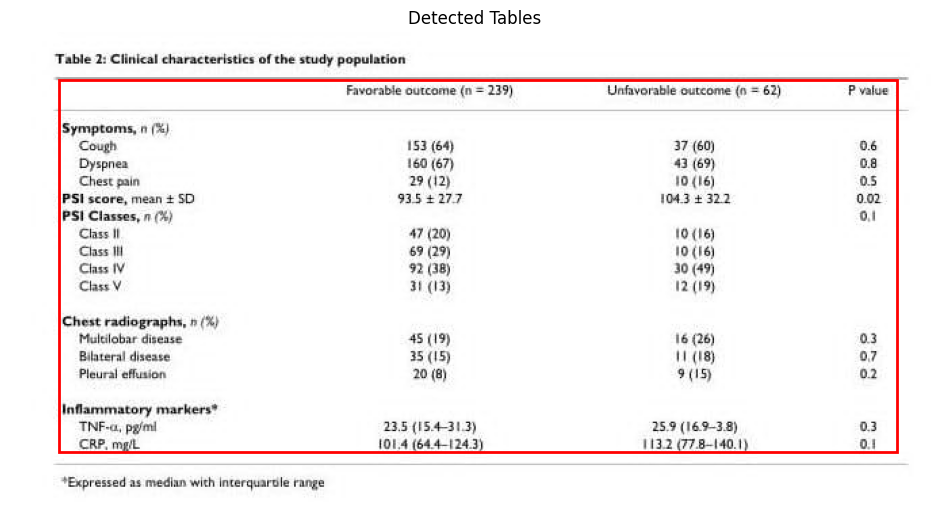


Processing Table 1...
Loading /kaggle/input/segmentation-model/other/default/1/seg_row_v0.onnx for ONNX Runtime inference...
requirements: Ultralytics requirement ['onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 MB 112.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 195.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 221.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 17.4s, installed 1 package: ['onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect




2024-10-23 06:07:42.526865792 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 4 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


0: 640x640 29 table rows, 67.4ms
Speed: 4.3ms preprocess, 67.4ms inference, 118.7ms postprocess per image at shape (1, 3, 640, 640)


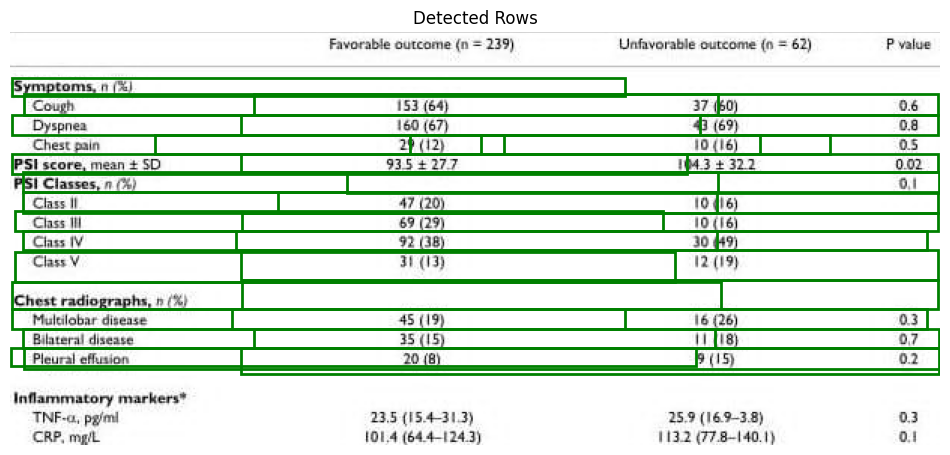

Loading /kaggle/input/segmentation-model/other/default/1/seg_col_v0.onnx for ONNX Runtime inference...



2024-10-23 06:07:52.755512587 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 4 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


0: 640x640 4 table columns, 67.4ms
Speed: 3.6ms preprocess, 67.4ms inference, 32.2ms postprocess per image at shape (1, 3, 640, 640)


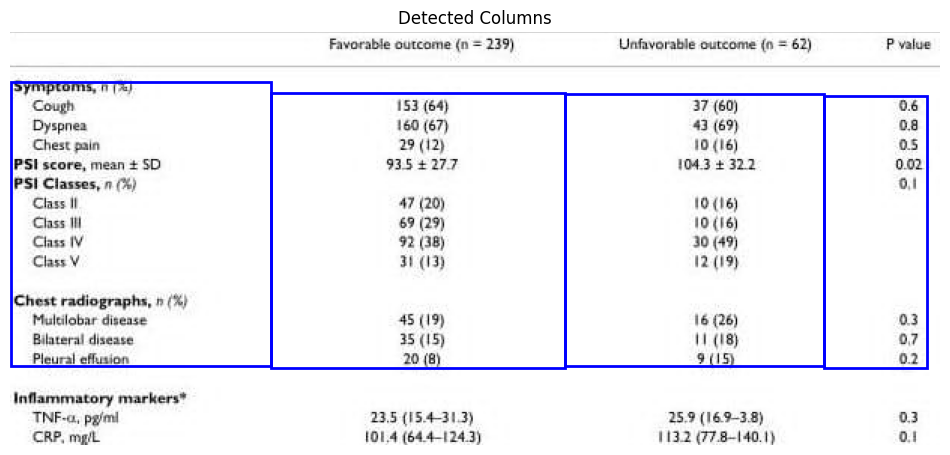

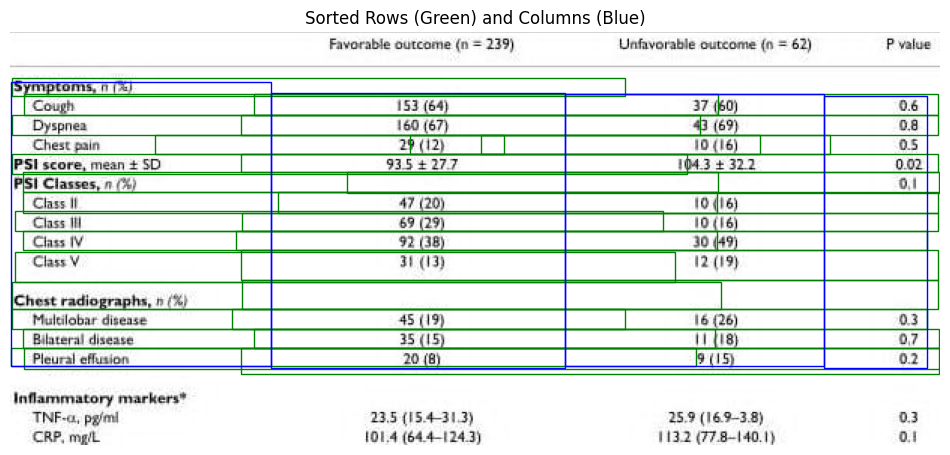

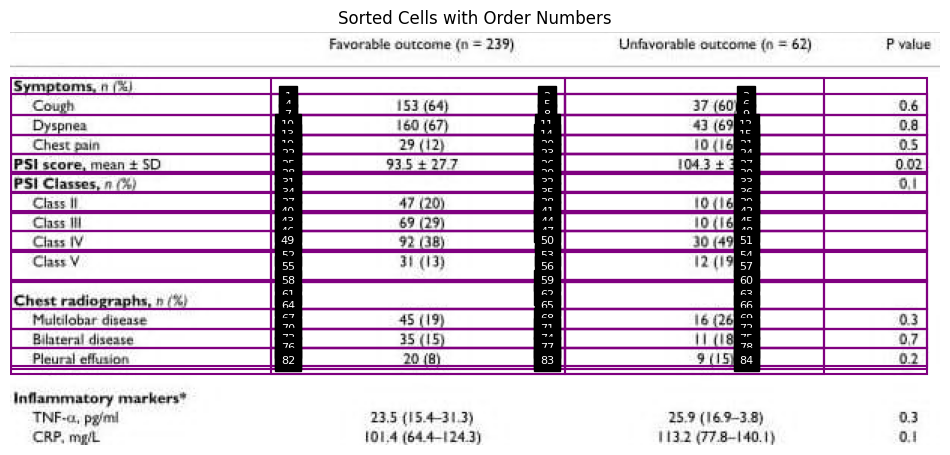

Mapping Cells to Rows and Columns:
Cell at (row=0, col=0): Symptons n (e Coveh
Cell at (row=0, col=1): 
Cell at (row=0, col=2): 
Cell at (row=1, col=0): 
Cell at (row=1, col=1): 
Cell at (row=1, col=2): 
Cell at (row=2, col=0): Dyspnel I60 (671 Coumh
Cell at (row=2, col=1): J60 (67
Cell at (row=2, col=2): 43 (69
Cell at (row=3, col=0): 
Cell at (row=3, col=1): 
Cell at (row=3, col=2): 
Cell at (row=4, col=0): Duspnel Cheshn
Cell at (row=4, col=1): 
Cell at (row=4, col=2): 
Cell at (row=5, col=0): 
Cell at (row=5, col=1): 
Cell at (row=5, col=2): 
Cell at (row=6, col=0): 
Cell at (row=6, col=1): 
Cell at (row=6, col=2): 
Cell at (row=7, col=0): Chest paln PSIaore
Cell at (row=7, col=1): + 377
Cell at (row=7, col=2): 002
Cell at (row=8, col=0): PSi score
Cell at (row=8, col=1): +32 2
Cell at (row=8, col=2): 
Cell at (row=9, col=0): PSI score een 935 $ 177 PSI Classes
Cell at (row=9, col=1): 93.5 $ 177 404 3 1+32 2
Cell at (row=9, col=2): 104} + 32 2
Cell at (row=10, col=0): 
Cell at (row

Symptons n (e Coveh,,
,,
Dyspnel I60 (671 Coumh,J60 (67,43 (69
,,
Duspnel Cheshn,,
,,
,,
Chest paln PSIaore,+ 377,002
PSi score,+32 2,
PSI score een 935 $ 177 PSI Classes,93.5 $ 177 404 3 1+32 2,104} + 32 2
,,


HTML table saved to /kaggle/working/output_table_1.html


In [6]:
# Example usage
process_image('/kaggle/input/44/other/default/1/ti xung.jpg')